# Stream AC($\lambda$) algorithm with MuJoCo Gym environments:

The following code is distributed under the Creative Commons Attribution-NonCommercial 4.0. License See this [link](https://creativecommons.org/licenses/by-nc/4.0/deed.en) for more information.

### 1. Install necessary packages:

In [ ]:
!pip install gymnasium==0.29.1
!pip install numpy==1.26.4
!pip install torch==2.3.0
!pip install mujoco==2.3.7
!apt-get install -y python3-opengl xvfb ffmpeg
!pip install pyvirtualdisplay imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 2. Import necessary libraries:

In [ ]:
import torch, math
import numpy as np
import gymnasium as gym
import os, pickle, argparse
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

### 3. Implement the ObGD optimizer:

In [ ]:
class ObGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1.0, gamma=0.99, lamda=0.8, kappa=2.0):
        defaults = dict(lr=lr, gamma=gamma, lamda=lamda, kappa=kappa)
        super(ObGD, self).__init__(params, defaults)
    def step(self, delta, reset=False):
        z_sum = 0.0
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                if len(state) == 0:
                    state["eligibility_trace"] = torch.zeros_like(p.data)
                e = state["eligibility_trace"]
                e.mul_(group["gamma"] * group["lamda"]).add_(p.grad, alpha=1.0)
                z_sum += e.abs().sum().item()

        delta_bar = max(abs(delta), 1.0)
        dot_product = delta_bar * z_sum * group["lr"] * group["kappa"]
        if dot_product > 1:
            step_size = group["lr"] / dot_product
        else:
            step_size = group["lr"]

        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                e = state["eligibility_trace"]
                p.data.add_(delta * e, alpha=-step_size)
                if reset:
                    e.zero_()

### 4. Implement sparse initialization:

In [ ]:
def sparse_init(tensor, sparsity, type='uniform'):

    if tensor.ndimension() == 2:
        fan_out, fan_in = tensor.shape

        num_zeros = int(math.ceil(sparsity * fan_in))

        with torch.no_grad():
            if type == 'uniform':
                tensor.uniform_(-math.sqrt(1.0 / fan_in), math.sqrt(1.0 / fan_in))
            elif type == 'normal':
                tensor.normal_(0, math.sqrt(1.0 / fan_in))
            else:
                raise ValueError("Unknown initialization type")
            for col_idx in range(fan_out):
                row_indices = torch.randperm(fan_in)
                zero_indices = row_indices[:num_zeros]
                tensor[col_idx, zero_indices] = 0
        return tensor

    elif tensor.ndimension() == 4:
        channels_out, channels_in, h, w = tensor.shape
        fan_in, fan_out = channels_in*h*w, channels_out*h*w

        num_zeros = int(math.ceil(sparsity * fan_in))

        with torch.no_grad():
            if type == 'uniform':
                tensor.uniform_(-math.sqrt(1.0 / fan_in), math.sqrt(1.0 / fan_in))
            elif type == 'normal':
                tensor.normal_(0, math.sqrt(1.0 / fan_in))
            else:
                raise ValueError("Unknown initialization type")
            for out_channel_idx in range(channels_out):
                indices = torch.randperm(fan_in)
                zero_indices = indices[:num_zeros]
                tensor[out_channel_idx].reshape(channels_in*h*w)[zero_indices] = 0
        return tensor
    else:
        raise ValueError("Only tensors with 2 or 4 dimensions are supported")

### 5. Implement observation normalization and reward scaling:

In [ ]:
class SampleMeanStd:
    def __init__(self, shape=()):
        self.mean = np.zeros(shape, "float64")
        self.var = np.ones(shape, "float64")
        self.p = np.ones(shape, "float64")
        self.count = 0

    def update(self, x):
        if self.count == 0:
            self.mean = x
            self.p = np.zeros_like(x)
        self.mean, self.var, self.p, self.count = self.update_mean_var_count_from_moments(self.mean, self.p, self.count, x*1.0)

    def update_mean_var_count_from_moments(self, mean, p, count, sample):
        new_count = count + 1
        new_mean = mean + (sample - mean) / new_count
        p = p + (sample - mean) * (sample - new_mean)
        new_var = 1 if new_count < 2 else p / (new_count - 1)
        return new_mean, new_var, p, new_count

class NormalizeObservation(gym.Wrapper, gym.utils.RecordConstructorArgs):
    def __init__(self, env: gym.Env, epsilon: float = 1e-8):
        gym.utils.RecordConstructorArgs.__init__(self, epsilon=epsilon)
        gym.Wrapper.__init__(self, env)
        try:
            self.num_envs = self.get_wrapper_attr("num_envs")
            self.is_vector_env = self.get_wrapper_attr("is_vector_env")
        except AttributeError:
            self.num_envs = 1
            self.is_vector_env = False

        if self.is_vector_env:
            self.obs_stats = SampleMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_stats = SampleMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, terminateds, truncateds, infos = self.env.step(action)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, terminateds, truncateds, infos

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self.is_vector_env:
            return self.normalize(obs), info
        else:
            return self.normalize(np.array([obs]))[0], info

    def normalize(self, obs):
        self.obs_stats.update(obs)
        return (obs - self.obs_stats.mean) / np.sqrt(self.obs_stats.var + self.epsilon)

class ScaleReward(gym.core.Wrapper, gym.utils.RecordConstructorArgs):
    def __init__(self, env: gym.Env, gamma: float = 0.99, epsilon: float = 1e-8):
        gym.utils.RecordConstructorArgs.__init__(self, gamma=gamma, epsilon=epsilon)
        gym.Wrapper.__init__(self, env)
        try:
            self.num_envs = self.get_wrapper_attr("num_envs")
            self.is_vector_env = self.get_wrapper_attr("is_vector_env")
        except AttributeError:
            self.num_envs = 1
            self.is_vector_env = False
        self.reward_stats = SampleMeanStd(shape=())
        self.reward_trace = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, terminateds, truncateds, infos = self.env.step(action)
        if not self.is_vector_env:
            rews = np.array([rews])
        term = terminateds or truncateds
        self.reward_trace = self.reward_trace * self.gamma * (1 - term) + rews
        rews = self.normalize(rews)
        if not self.is_vector_env:
            rews = rews[0]
        return obs, rews, terminateds, truncateds, infos

    def normalize(self, rews):
        self.reward_stats.update(self.reward_trace)
        return rews / np.sqrt(self.reward_stats.var + self.epsilon)

### 6. Implement the Stream AC($\lambda$) agent:

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        sparse_init(m.weight, sparsity=0.9)
        m.bias.data.fill_(0.0)

class Actor(nn.Module):
    def __init__(self, n_obs=11, n_actions=3, hidden_size=128):
        super(Actor, self).__init__()
        self.fc_layer   = nn.Linear(n_obs, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.linear_mu = nn.Linear(hidden_size, n_actions)
        self.linear_std = nn.Linear(hidden_size, n_actions)
        self.apply(initialize_weights)

    def forward(self, x):
        x = self.fc_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        x = self.hidden_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        mu = self.linear_mu(x)
        pre_std = self.linear_std(x)
        std = F.softplus(pre_std)
        return mu, std

class Critic(nn.Module):
    def __init__(self, n_obs=11, hidden_size=128):
        super(Critic, self).__init__()
        self.fc_layer   = nn.Linear(n_obs, hidden_size)
        self.hidden_layer  = nn.Linear(hidden_size, hidden_size)
        self.linear_layer  = nn.Linear(hidden_size, 1)
        self.apply(initialize_weights)

    def forward(self, x):
        x = self.fc_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        x = self.hidden_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        return self.linear_layer(x)

class StreamAC(nn.Module):
    def __init__(self, n_obs=11, n_actions=3, hidden_size=128, lr=1.0, gamma=0.99, lamda=0.8, kappa_policy=3.0, kappa_value=2.0):
        super(StreamAC, self).__init__()
        self.gamma = gamma
        self.policy_net = Actor(n_obs=n_obs, n_actions=n_actions, hidden_size=hidden_size)
        self.value_net = Critic(n_obs=n_obs, hidden_size=hidden_size)
        self.optimizer_policy = ObGD(self.policy_net.parameters(), lr=lr, gamma=gamma, lamda=lamda, kappa=kappa_policy)
        self.optimizer_value = ObGD(self.value_net.parameters(), lr=lr, gamma=gamma, lamda=lamda, kappa=kappa_value)

    def pi(self, x):
        return self.policy_net(x)

    def v(self, x):
        return self.value_net(x)

    def sample_action(self, s):
        x = torch.from_numpy(s).float()
        mu, std = self.pi(x)
        dist = Normal(mu, std)
        return dist.sample().numpy()

    def update_params(self, s, a, r, s_prime, done, entropy_coeff):
        done_mask = 0 if done else 1
        s, a, r, s_prime, done_mask = torch.tensor(np.array(s), dtype=torch.float), torch.tensor(np.array(a)), \
                                         torch.tensor(np.array(r)), torch.tensor(np.array(s_prime), dtype=torch.float), \
                                         torch.tensor(np.array(done_mask), dtype=torch.float)

        v_s, v_prime = self.v(s), self.v(s_prime)
        td_target = r + self.gamma * v_prime * done_mask
        delta = td_target - v_s

        mu, std = self.pi(s)
        dist = Normal(mu, std)

        log_prob_pi = -(dist.log_prob(a)).sum()
        value_output = -v_s
        entropy_pi = -entropy_coeff * dist.entropy().sum() * torch.sign(delta).item()
        self.optimizer_value.zero_grad()
        self.optimizer_policy.zero_grad()
        value_output.backward()
        (log_prob_pi + entropy_pi).backward()
        self.optimizer_policy.step(delta.item(), reset=done)
        self.optimizer_value.step(delta.item(), reset=done)

### 7. Add time information to the observation vectors:

In [ ]:
class AddTimeInfo(gym.core.Wrapper):
    def __init__(self, env: gym.Env):
        super().__init__(env)
        if self.env.num_envs > 1:
            raise ValueError("AddTimeInfo only supports single environments")
        self.epi_time = -0.5
        if 'dm_control' in env.spec.id:
            self.time_limit = 1000
        else:
            self.time_limit = env.spec.max_episode_steps
        self.obs_space_size = self.observation_space.shape[0] + self.env.num_envs
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_space_size,), dtype=np.float32)
        if not (isinstance(self.action_space, gym.spaces.Box) or isinstance(self.action_space, gym.spaces.Discrete)):
            raise ValueError("Unsupported action space")

    def step(self, action):
        obs, rews, terminateds, truncateds, infos = self.env.step(action)
        obs = np.concatenate((obs, np.array([self.epi_time] * self.env.num_envs)))
        self.epi_time += 1.0 / self.time_limit
        return obs, rews, terminateds, truncateds, infos

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.epi_time = -0.5
        obs = np.concatenate((obs, np.array([self.epi_time])))
        return obs, info

### 7. Define agent-enviroment interaction loop:

In [ ]:
def agent_env_interaction(env_name='Ant-v4', seed=0, lr=1.0, gamma=0.99, lamda=0.8, total_steps=2_000_000, entropy_coeff=0.01, kappa_policy=3.0, kappa_value=2.0, debug=True, save_agent=True, load_agent=None, render=False):
    torch.manual_seed(seed); np.random.seed(seed)
    env = gym.make(env_name, render_mode="rgb_array", width=320, height=240)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = gym.wrappers.ClipAction(env)
    env = ScaleReward(env, gamma=gamma)
    env = NormalizeObservation(env)
    env = AddTimeInfo(env)
    agent = StreamAC(n_obs=env.observation_space.shape[0], n_actions=env.action_space.shape[0], lr=lr, gamma=gamma, lamda=lamda, kappa_policy=kappa_policy, kappa_value=kappa_value)

    if render:
      from pyvirtualdisplay import Display
      virtual_display = Display(visible=0, size=(320, 240))
      virtual_display.start()

    if load_agent is not None:
        agent.load_state_dict(torch.load(load_agent+"/seed_{}.pth".format(seed), weights_only=True))
        reward_stats, obs_stats = pickle.load(open(load_agent+"/stats_data_{}.pkl".format(seed), "rb"))
        env.obs_stats.mean = obs_stats.mean
        env.obs_stats.var = obs_stats.var
        env.obs_stats.count = obs_stats.count
        env.obs_stats.p = obs_stats.p
        env.reward_stats.mean = reward_stats.mean
        env.reward_stats.var = reward_stats.var
        env.reward_stats.count = reward_stats.count
        env.reward_stats.p = reward_stats.p

    if debug:
        print("seed: {}".format(seed), "env: {}".format(env.spec.id))

    returns, term_time_steps, frames = [], [], []
    s, _ = env.reset(seed=seed)
    for t in range(1, total_steps+1):
        a = agent.sample_action(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        agent.update_params(s, a, r, s_prime,  terminated or truncated, entropy_coeff)
        s = s_prime
        if render:
            if t % 4 == 0:
                frame = env.render()
                frames.append(frame)
        if terminated or truncated:
            if debug:
                print("Episodic Return: {}, Time Step {}".format(info['episode']['r'][0], t))
            returns.append(info['episode']['r'][0])
            term_time_steps.append(t)
            terminated, truncated = False, False
            s, _ = env.reset()
    env.close()

    if save_agent:
        save_dir = "data_stream_ac_{}".format(env.spec.id)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        with open(os.path.join(save_dir, "seed_{}.pkl".format(seed)), "wb") as f:
            pickle.dump((returns, term_time_steps, env_name), f)
        save_dir = "stream_ac_{}".format(env.spec.id)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(agent.state_dict(), os.path.join(save_dir, "seed_{}.pth".format(seed)))
        reward_stats = env.reward_stats
        obs_stats = env.obs_stats
        with open(os.path.join(save_dir, "stats_data_{}.pkl".format(seed)), "wb") as f:
            pickle.dump((reward_stats, obs_stats), f)

    return frames

### 8. Set hyperparameters and start agent-environment interaction:

In [ ]:
agent_env_interaction(env_name='Ant-v4',
                      seed=0,
                      lr=1.0,
                      gamma=0.99,
                      lamda=0.8,
                      total_steps=500_000,
                      entropy_coeff=0.01,
                      kappa_policy=3.0,
                      kappa_value=2.0,
                      save_agent=True,
                      debug=True,
)

seed: 0 env: Ant-v4
Episodic Return: -39.67570495605469, Time Step 155
Episodic Return: -65.718017578125, Time Step 309
Episodic Return: -34.864707946777344, Time Step 354
Episodic Return: -22.299257278442383, Time Step 388
Episodic Return: -7.721120834350586, Time Step 418
Episodic Return: -25.978851318359375, Time Step 456
Episodic Return: -372.7948913574219, Time Step 1456
Episodic Return: -93.25806427001953, Time Step 1610
Episodic Return: -45.12826919555664, Time Step 1658
Episodic Return: -26.670970916748047, Time Step 1795
Episodic Return: -15.992010116577148, Time Step 1838
Episodic Return: -11.953166961669922, Time Step 1868
Episodic Return: -343.0804138183594, Time Step 2868
Episodic Return: -89.17655181884766, Time Step 3075
Episodic Return: -16.767683029174805, Time Step 3128
Episodic Return: -15.996119499206543, Time Step 3155
Episodic Return: -25.12393569946289, Time Step 3307
Episodic Return: -19.310684204101562, Time Step 3330
Episodic Return: -11.572486877441406, Time 

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_stats` for environment variables or `env.get_wrapper_attr('reward_stats')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.obs_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obs_stats` for environment variables or `env.get_wrapper_attr('obs_stats')` that will search the reminding wrappers.
  logger.warn(


[]

### 10. Plot the learning curve:

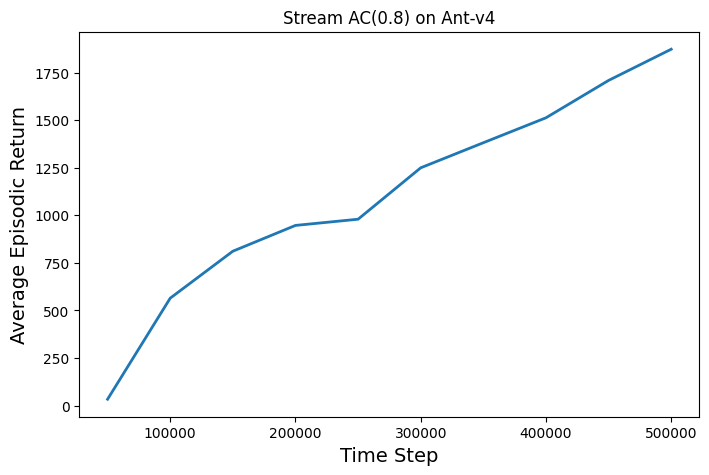

In [ ]:
import numpy as np
import pickle, os
import matplotlib.pyplot as plt

def avg_return_curve(x, y, stride, total_steps):
    assert len(x) == len(y)
    num_runs = len(x)
    avg_ret = np.zeros(total_steps // stride)
    stderr_ret = np.zeros(total_steps // stride)
    avg_ret2 = np.zeros(total_steps // stride)
    stderr_ret2 = np.zeros(total_steps // stride)
    steps = np.arange(stride, total_steps + stride, stride)
    num_rets = np.zeros(total_steps // stride)
    individ_avg_rets_per_run = []
    for i in range(0, total_steps // stride):
        rets = []
        avg_rets_per_run = []
        for run in range(num_runs):
            xa = np.array(x[run])
            ya = np.array(y[run])
            rets.append(ya[np.logical_and(i * stride < xa, xa <= (i + 1) * stride)].tolist())
            avg_rets_per_run.append(np.mean(rets[-1]))
        individ_avg_rets_per_run.append(avg_rets_per_run)
        flat_rets = np.array([ret for l in rets for ret in l])
        num_rets[i] = flat_rets.shape[0]
        avg_ret[i] = flat_rets.mean()
        stderr_ret[i] = flat_rets.std() / np.sqrt(num_rets[i])
        avg_ret2[i] = np.mean(avg_rets_per_run)
        stderr_ret2[i] = np.std(avg_rets_per_run) / np.sqrt(num_runs)
    return steps, avg_ret, stderr_ret, num_rets, avg_ret2, stderr_ret2, individ_avg_rets_per_run

def plot(data_dir, int_space, total_steps):
    plt.figure(figsize=(8, 5))
    all_termination_time_steps, all_episodic_returns, env_name = [], [], ''
    for file in os.listdir(data_dir):
        if file.endswith(".pkl"):
            with open(os.path.join(data_dir, file), "rb") as f:
                episodic_returns, termination_time_steps, env_name = pickle.load(f)
                all_termination_time_steps.append(termination_time_steps)
                all_episodic_returns.append(episodic_returns)

    (
        steps,
        avg_ret,
        stderr_ret,
        num_rets,
        avg_ret2,
        stderr_ret2,
        individ_avg_rets_per_run,
    ) = avg_return_curve(all_termination_time_steps, all_episodic_returns, int_space, total_steps)

    plt.plot(steps, avg_ret2, linewidth=2.0)
    plt.fill_between(steps, avg_ret2 - stderr_ret2, avg_ret2 + stderr_ret2, alpha=0.4)

    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel(f"Average Episodic Return", fontsize=14)
    plt.title(r"Stream AC(0.8) on Ant-v4")
    plt.show()

plot(data_dir='data_stream_ac_Ant-v4', int_space=50_000, total_steps=500_000)

## 10. Load agents and continue the interaction

Let's save the actor and critic networks along with the observations mean/std and reward trace std. We also save the frames to visualize the behavior next.

In [ ]:
frames = agent_env_interaction(env_name='Ant-v4',
                      seed=0,
                      lr=1.0,
                      gamma=0.99,
                      lamda=0.8,
                      total_steps=2_000,
                      entropy_coeff=0.01,
                      kappa_policy=3.0,
                      kappa_value=2.0,
                      save_agent=False,
                      load_agent="stream_ac_Ant-v4",
                      render=True,
                      debug=True,
)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.obs_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obs_stats` for environment variables or `env.get_wrapper_attr('obs_stats')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_stats` for environment variables or `env.get_wrapper_attr('reward_stats')` that will search the reminding wrappers.
  logger.warn(


seed: 0 env: Ant-v4
Episodic Return: 2150.37646484375, Time Step 1000
Episodic Return: 2078.7783203125, Time Step 2000


### 10. See how the behavior looks like:




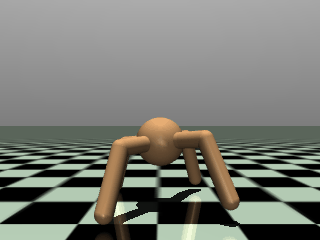

In [ ]:
import imageio
# Save as a GIF
gif_path = '/content/Ant-v4.gif'
imageio.mimsave(gif_path, frames, format='GIF', fps=8)
# Display the GIF
from IPython.display import Image
Image(gif_path)